# Low-rank nonnegative tensor approximation via alternating projections and sketching

In [2]:
##
%reload_ext autoreload
%autoreload 2
##

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio

from time import time
import sys #
sys.path.append('./src') #

from truncatedSvd import TruncatedSvd
from experiment import Experiment

/home/azamat/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
%%bash
lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Address sizes:                   39 bits physical, 48 bits virtual
Byte Order:                      Little Endian
CPU(s):                          4
On-line CPU(s) list:             0-3
Vendor ID:                       GenuineIntel
Model name:                      Intel(R) Core(TM) i3-8130U CPU @ 2.20GHz
CPU family:                      6
Model:                           142
Thread(s) per core:              2
Core(s) per socket:              2
Socket(s):                       1
Stepping:                        10
BogoMIPS:                        4416.00
Flags:                           fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology cpuid pni pclmulqdq vmx ssse3 fma cx16 pcid sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single 

## 1. Multidimensional Gaussian mixture

In [4]:
t0 = time()

N = 128
N1 = N
N2 = N
N3 = N
A = np.zeros([N1, N2,N3])
cov_mat = np.random.uniform(0, 1, [3,3])
cov_mat = cov_mat @ cov_mat.T
cov_mat = cov_mat / np.linalg.norm(cov_mat)
cov_mat2 = np.random.uniform(0, 1, [3,3])
cov_mat2 = cov_mat2 @ cov_mat2.T
cov_mat2 = cov_mat2 / np.linalg.norm(cov_mat2)

cov_mat3 = np.random.uniform(0, 1, [3,3])
cov_mat3 = cov_mat3 @ cov_mat3.T
cov_mat3 = cov_mat3 / np.linalg.norm(cov_mat3)

h = 4. / N
for i in range(N1):
    for j in range(N2):
        for k in range(N3):
            point = np.array([i*h, j*h, k*h])
            A[i,j,k] = np.exp(-point @ cov_mat  @ point) +\
                       np.exp(-point @ cov_mat2 @ point) +\
                       np.exp(-point @ cov_mat3 @ point)
            
print('%d s.' % (time() - t0))

155 s.


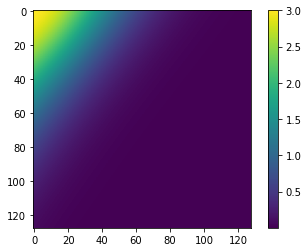

In [9]:
plt.imshow(A[:, :, 0])
_ = plt.colorbar()

In [56]:
nsthosvdTruncatedSvdList = []
nsthosvdTruncatedSvdList.append(TruncatedSvd('SVDr'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('HMT',   p=1,  k=15))
nsthosvdTruncatedSvdList.append(TruncatedSvd('HMT',   p=0,  k=16))
nsthosvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=10, l=25))
# nsthosvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=6,  l=11))

nttsvdTruncatedSvdList = []
nttsvdTruncatedSvdList.append(TruncatedSvd('SVDr'))
nttsvdTruncatedSvdList.append(TruncatedSvd('HMT',   p=1, k=14))
nttsvdTruncatedSvdList.append(TruncatedSvd('HMT',   p=0, k=14))
nttsvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=7, l=29))
# nttsvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=6, l=10))


tuckerRank = (5, 5, 5)
ttRank = (5, 5)
itersNum = 100

ex = Experiment(tensor=A,
                tuckerRank=tuckerRank,
                ttRank=ttRank,
                nsthosvdTruncatedSvdList=nsthosvdTruncatedSvdList,
                nttsvdTruncatedSvdList=nttsvdTruncatedSvdList)

In [57]:
ex.runInitialSvd()

TTSVD
-------------------------------------------
time (s.)                    |      3.02902
negative elements (fro)      |     0.000962
negative elements (che)      |     0.000012
negative elements (%)        |   8.69679451
relative error (fro)         | 0.0000515274
relative error (che)         | 0.0002881244
r2_score                     | 0.9999999972
compression                  |       468.11
-------------------------------------------
STHOSVD
-------------------------------------------
time (s.)                    |      0.89445
negative elements (fro)      |     0.001296
negative elements (che)      |     0.000014
negative elements (%)        |   4.18639183
relative error (fro)         | 0.0000549251
relative error (che)         | 0.0003607857
r2_score                     | 0.9999999968
compression                  |      1025.50
-------------------------------------------


In [58]:
ex.time(itersNum, nttsvd=True, nsthosvd=False)

NTTSVD
------------------------------------
SVD$_r$                 |  45.93 s.
HMT(1,14), Rad          |  11.42 s.
HMT(0,14), Rad          |   8.09 s.
Tropp(7,29), Rad        |   6.36 s.
------------------------------------


In [59]:
ex.time(itersNum, nttsvd=False, nsthosvd=True)

NSTHOSVD
------------------------------------
SVD$_r$                 |  45.62 s.
HMT(1,15), Rad          |  12.18 s.
HMT(0,16), Rad          |   8.53 s.
Tropp(10,25), Rad       |   7.54 s.
------------------------------------


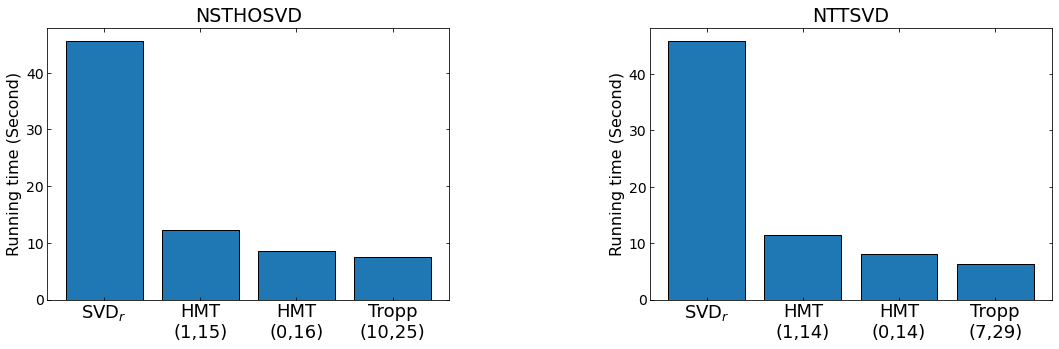

In [60]:
fig, ax = ex.plotRuntimes(figsize=(18, 5),
                          titlesize=19,
                          ylabelsize=16,
                          xticksize=18,
                          yticksize=14,
                          wspace=0.5,
                          paramsNewLine=True)

# fig.savefig('figs/gaussians_runtimes.pdf', transparent=True, bbox_inches='tight')

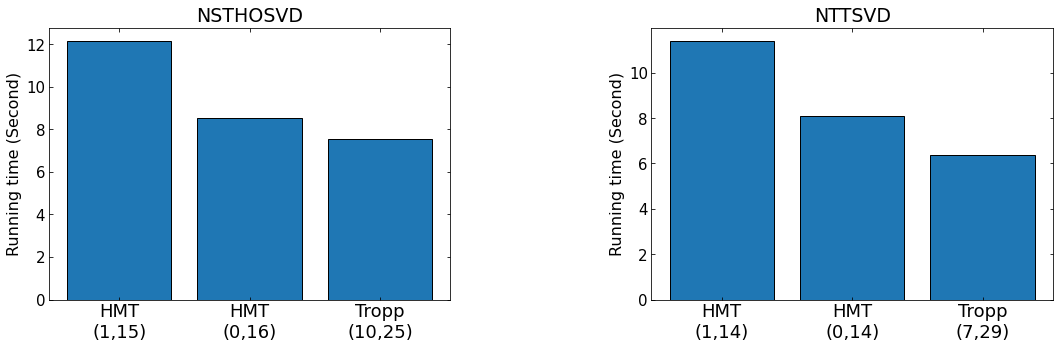

In [61]:
fig, ax = ex.plotRuntimes(figsize=(18, 5),
                          titlesize=19,
                          ylabelsize=16,
                          xticksize=18,
                          yticksize=15,
                          wspace=0.5,
                          paramsNewLine=True,
                          exclude=[0])

# fig.savefig('figs/gaussians_runtimes_rand.pdf', transparent=True, bbox_inches='tight')

In [51]:
ex.run(itersNum=itersNum)

NTTSVD
------------------------------------
SVD$_r$                  |  44.37 s.
HMT(1,14), Rad           |  13.54 s.
HMT(0,14), Rad           |  11.61 s.
Tropp(7,29), Rad         |   9.53 s.
------------------------------------
NSTHOSVD
------------------------------------
SVD$_r$                  |  51.40 s.
HMT(1,15), Rad           |  19.54 s.
HMT(0,16), Rad           |  20.92 s.
Tropp(10,25), Rad        |  15.44 s.
------------------------------------


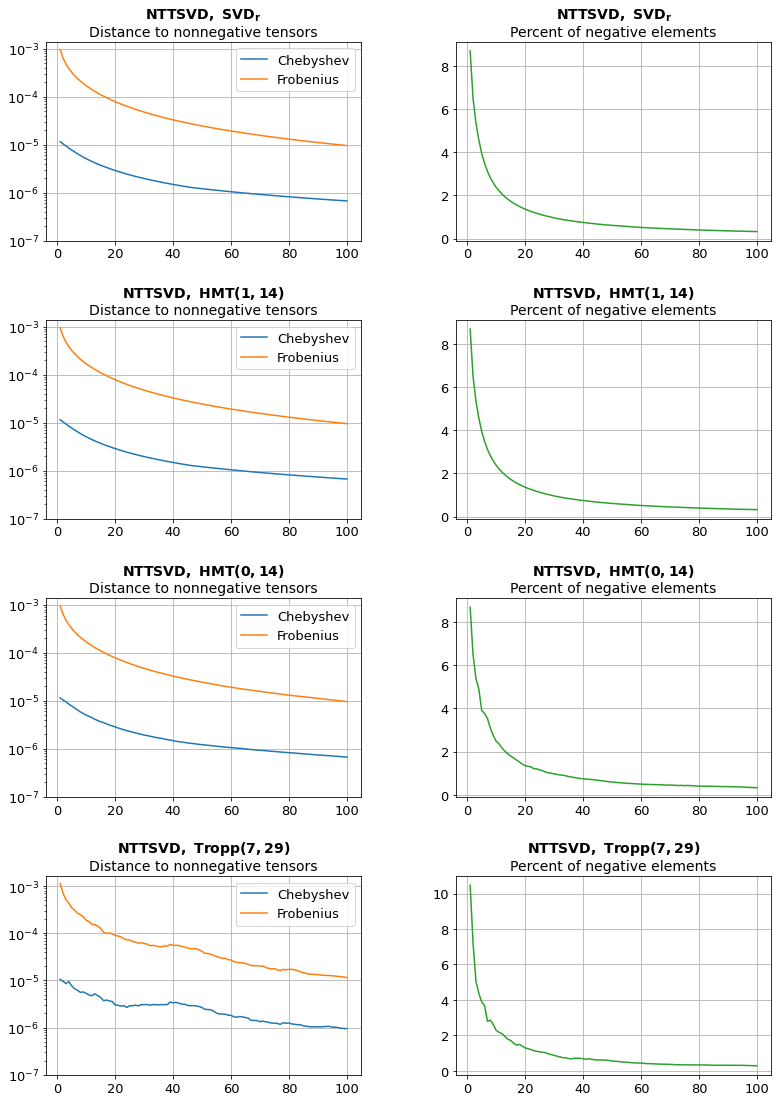

In [52]:
fig, ax = ex.plotConvergence2(nsthosvd=False,
                              figsize=(13, 19),
                              yticks=[10**(-x) for x in range(3, 8)],
                              hspace=0.4, wspace=0.3,
                              titlesize=14,
                              ticksize=13,
                              legendsize=13,
                              legendloc='upper right')

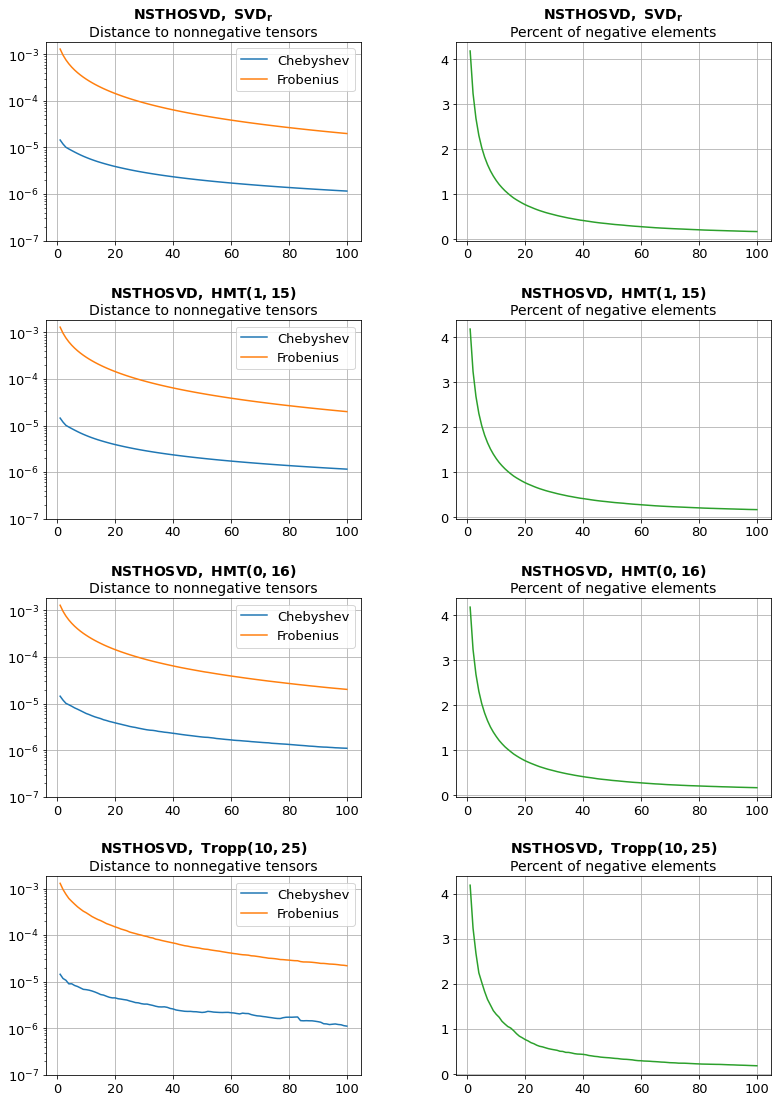

In [53]:
fig, ax = ex.plotConvergence2(nttsvd=False,
                              figsize=(13, 19),
                              yticks=[10**(-x) for x in range(3, 8)],
                              hspace=0.4, wspace=0.3,
                              titlesize=14,
                              ticksize=13,
                              legendsize=13,
                              legendloc='upper right')

In [49]:
ex.printErrors()

| NTTSVD                   | relative error (fro) | relative error (che) | r2_score |
------------------------------------------------------------------------------------
| SVD$_r$                  | 0.000051895558822776 | 0.000292731556424582 | 1.000000 |
| HMT(1,14), Rad           | 0.000051895558822762 | 0.000292731556075528 | 1.000000 |
| HMT(0,14), Rad           | 0.000051899837212349 | 0.000292658581749539 | 1.000000 |
| Tropp(7,29), Rad         | 0.000054833841601777 | 0.000258370709079081 | 1.000000 |
------------------------------------------------------------------------------------
| NSTHOSVD                 | relative error (fro) | relative error (che) | r2_score |
------------------------------------------------------------------------------------
| SVD$_r$                  | 0.000055753614477727 | 0.000368382208918957 | 1.000000 |
| HMT(1,15), Rad           | 0.000055753614477828 | 0.000368382208121668 | 1.000000 |
| HMT(0,16), Rad           | 0.000055756535796814 | 0.000

In [50]:
ex.printNegativeElements()

| NTTSVD                   | negative elements (%) |
----------------------------------------------------
| SVD$_r$                  |             0.3240108 |
| HMT(1,14), Rad           |             0.3240108 |
| HMT(0,14), Rad           |             0.3128052 |
| Tropp(7,29), Rad         |             0.2953529 |
----------------------------------------------------
| NSTHOSVD                 | negative elements (%) |
----------------------------------------------------
| SVD$_r$                  |             0.1645565 |
| HMT(1,15), Rad           |             0.1645565 |
| HMT(0,16), Rad           |             0.1642227 |
| Tropp(10,25), Rad        |             0.1596451 |
----------------------------------------------------


## 1. Hyperspectral Images (HSIs)

### 1.1. Washington, DC
https://github.com/JakobSig/HSI2RGB/blob/master/washington_hsi.mat

shape: (191, 307, 307)
min_elem: 0.0
max_elem: 1.0


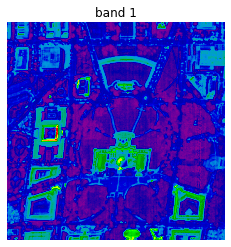

In [3]:
HSI_path = 'data/washington_hsi.mat'
HSI_mat = spio.loadmat(HSI_path)
HSI_data = HSI_mat['Y']
HSI_data = np.moveaxis(HSI_data, -1, 0)
img = HSI_data / HSI_data.max()

print('shape: %s\nmin_elem: %.1f\nmax_elem: %.1f' % (img.shape, img.min(), img.max()))
band = 1
plt.imshow(img[band], cmap='nipy_spectral')
plt.title(f'band {band}')
plt.axis('off')
plt.show()

In [8]:
ttSvdrList = []
ttSvdrList.append(TruncatedSvd('SVDr'))
ttSvdrList.append(TruncatedSvd('HMT',   p=1,   k=44,  distr='rademacher'))
ttSvdrList.append(TruncatedSvd('Tropp', k=78,  l=520, distr='rademacher'))


hoSvdrList = []
hoSvdrList.append(TruncatedSvd('SVDr'))
hoSvdrList.append(TruncatedSvd('HMT',   p=1,   k=68,  distr='rademacher'))
hoSvdrList.append(TruncatedSvd('Tropp', k=60,  l=819, distr='rademacher'))

In [18]:
hoRanks = [33, 40, 40]
ttRanks = [33, 33]
itersNum = 1AC

ex = Experiment(tensor=img, ttSvdrList=ttSvdrList, hoSvdrList=hoSvdrList)
ex.setRanks(hoRanks=hoRanks, ttRanks=ttRanks)

In [20]:
ex.runInitialSvd(ttsvd=True, hosvd=True)

TTSVD
----------------------------------------
time (s.)                    |   3.77454
negative elements (fro)      |   2.21814
negative elements (che)      |   0.06824
negative elements (%)        |   3.14982
relative error (fro)         |   0.18146
relative error (che)         |   0.45327
r2_score                     |   0.94200
compression                  |     51.32
----------------------------------------
STHOSVD
----------------------------------------
time (s.)                    |   4.11175
negative elements (fro)      |   2.08144
negative elements (che)      |   0.07091
negative elements (%)        |   2.89294
relative error (fro)         |   0.18450
relative error (che)         |   0.46223
r2_score                     |   0.94004
compression                  |    215.17
----------------------------------------


In [40]:
ex.timeit(itersNum=itersNum)

NTTSVD
------------------------------------
SVD$_r$                 |   3.74 s.
HMT(1,44), Rad          |   1.86 s.
Tropp(78,520), Rad      |   3.17 s.
------------------------------------
NSTHOSVD
------------------------------------
SVD$_r$                 |   4.31 s.
HMT(1,68), Rad          |   3.30 s.
Tropp(60,819), Rad      |   1.94 s.
------------------------------------


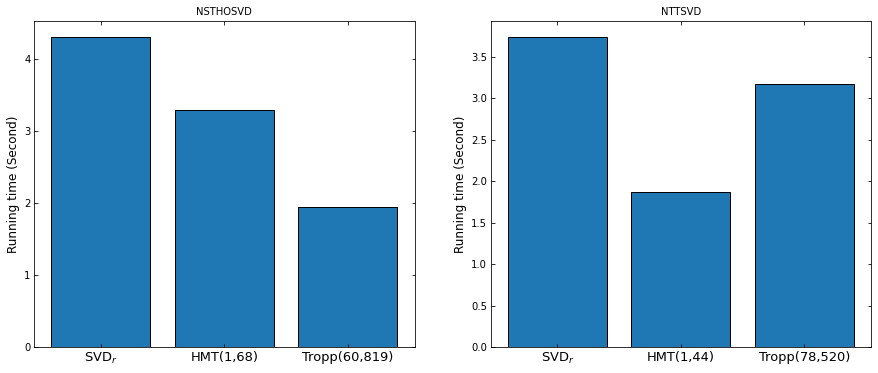

In [41]:
fig, ax = ex.plotRuntimes(figsize=(15, 6), ylabelsize=12, xticksize=13, wspace=0.2)
# fig.savefig('figs/washington_runtimes.pdf', transparent=True, bbox_inches='tight')

In [42]:
ex.run(itersNum=itersNum)

NTTSVD
------------------------------------
SVD$_r$                  |   4.51 s.
HMT(1,44), Rad           |   2.11 s.
Tropp(78,520), Rad       |   3.79 s.
------------------------------------
NSTHOSVD
------------------------------------
SVD$_r$                  |   4.57 s.
HMT(1,68), Rad           |   3.65 s.
Tropp(60,819), Rad       |   2.42 s.
------------------------------------


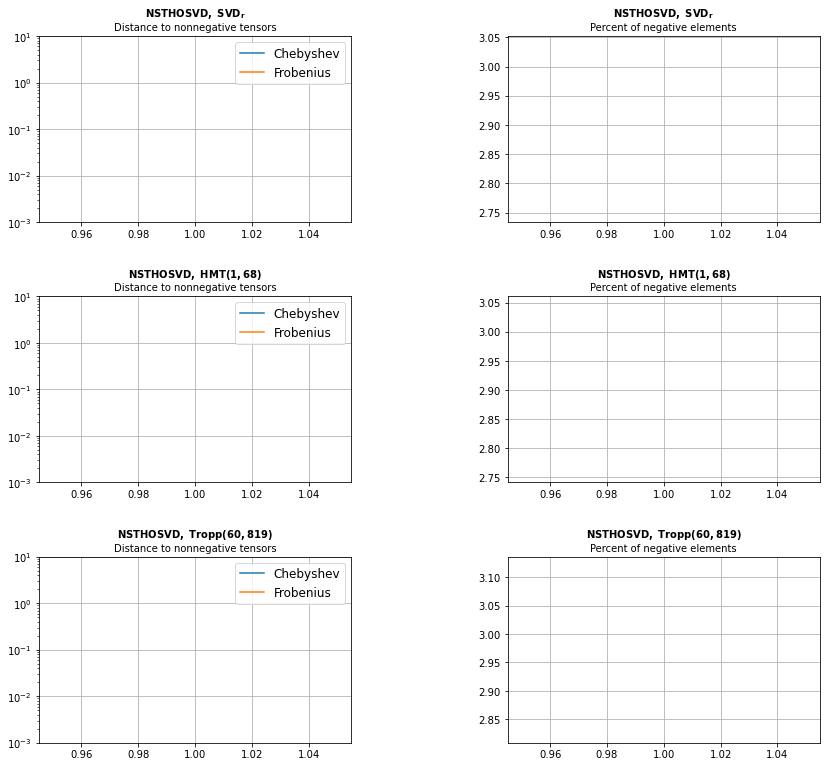

In [43]:
fig, ax = ex.plotConvergence2(ttsvd=False,
                              yticks=[10**(-x) for x in range(-1, 4)],
                              legendsize=12,
                              figsize=(14, 13),
                              wspace=0.5, hspace=0.4)

# for i in range(ax.shape[0]):   
#     extent = ax[i,0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#     extent.x0 -= 0.5
#     extent.x1 += 5.7
#     extent.y1 += 0.5
#     extent.y0 -= 0.3
#     fname = 'figs/washington_conv_ho_%d.pdf' % i
#     fig.savefig(fname, transparent=True, bbox_inches=extent)

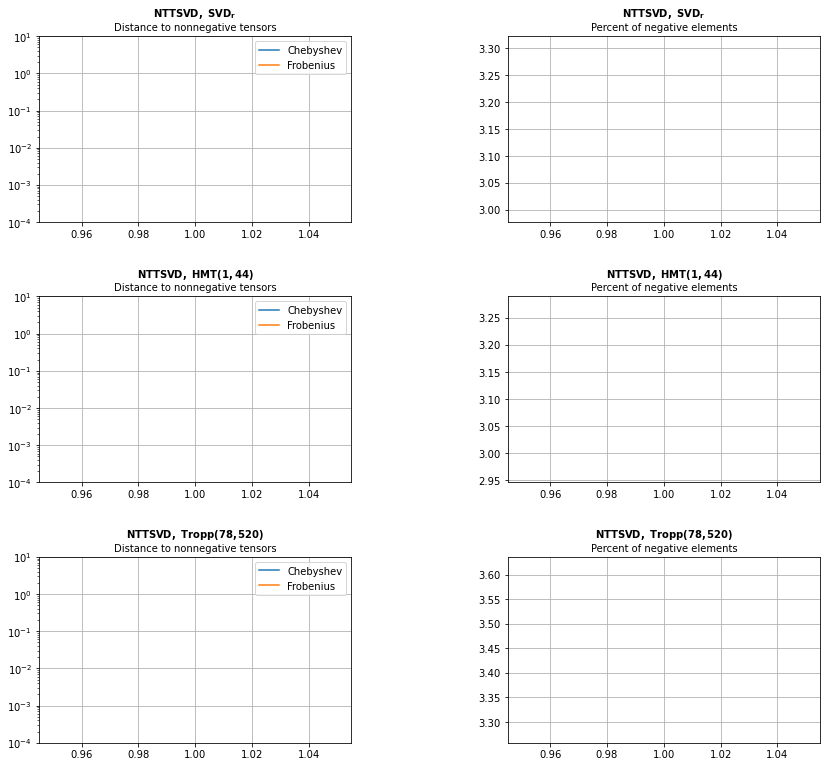

In [100]:
fig, ax = ex.plotConvergence2(hosvd=False,
                             yticks=[10**(-x) for x in range(-1, 5)],
                             figsize=(14, 13),
                             wspace=0.5, hspace=0.4)

# for i in range(ax.shape[0]):   
#     extent = ax[i,0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#     extent.x0 -= 0.5
#     extent.x1 += 5.7
#     extent.y1 += 0.5
#     extent.y0 -= 0.3
#     fname = 'figs/washington_conv_tt_%d.pdf' % i
#     fig.savefig(fname, transparent=True, bbox_inches=extent)

In [133]:
ex.printErrors()

| NTTSVD                   | relative error (fro) | relative error (che) | r2_score |
------------------------------------------------------------------------------------
| SVD$_r$                  |              0.18146 |              0.45327 | 0.941999 |
| HMT(1,44), Rad           |              0.18569 |              0.45940 | 0.939265 |
| Tropp(78,520), Rad       |              0.21329 |              0.41841 | 0.919864 |
------------------------------------------------------------------------------------
| NSTHOSVD                 | relative error (fro) | relative error (che) | r2_score |
------------------------------------------------------------------------------------
| SVD$_r$                  |              0.18450 |              0.46223 | 0.940036 |
| HMT(1,68), Rad           |              0.18542 |              0.46554 | 0.939437 |
| Tropp(60,819), Rad       |              0.23355 |              0.46899 | 0.903918 |
---------------------------------------------------------

In [134]:
ex.printNegativeElements()

| NTTSVD                   | negative elements (%) |
----------------------------------------------------
| SVD$_r$                  |             3.1498216 |
| HMT(1,44), Rad           |             3.1175244 |
| Tropp(78,520), Rad       |             3.4468237 |
----------------------------------------------------
| NSTHOSVD                 | negative elements (%) |
----------------------------------------------------
| SVD$_r$                  |             2.8929439 |
| HMT(1,68), Rad           |             2.8918829 |
| Tropp(60,819), Rad       |             2.8255442 |
----------------------------------------------------


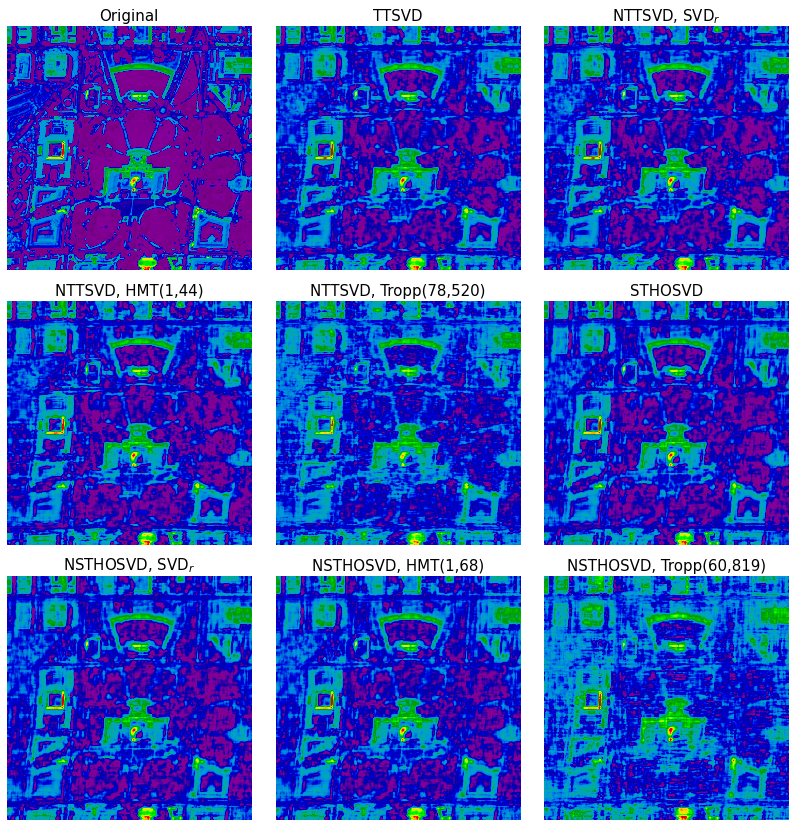

In [132]:
fig, ax = ex.showApproximations(band=50,
                                figsize=(14, 14.7),
                                wspace=0.1, hspace=0.1,
                                titlesize=15,
                                cmap='nipy_spectral')

# fig.savefig('figs/washington_approximations.pdf', transparent=True, bbox_inches='tight')

### 1.2. WHU-Hi-LongKou
http://rsidea.whu.edu.cn/resource_WHUHi_sharing.htm

shape: (270, 550, 400)
min_elem: 0.0
max_elem: 28.1


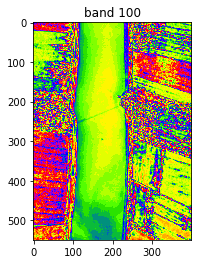

In [4]:
# original image

HSI_path = 'data/WHU_Hi_LongKou.mat'
HSI_mat = spio.loadmat(HSI_path)
HSI_data = HSI_mat['WHU_Hi_LongKou']
HSI_data = np.moveaxis(HSI_data, -1, 0)

img = HSI_data

print('shape: %s\nmin_elem: %.1f\nmax_elem: %.1f' % (img.shape, img.min(), img.max()))
band = 100
plt.imshow(img[band], cmap='prism')
plt.title(f'band {band}')
plt.show()

shape: (270, 200, 200)
min_elem: 0.0
max_elem: 1.0


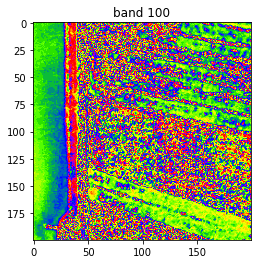

In [5]:
# subimage

HSI_path = 'data/WHU_Hi_LongKou.mat'
HSI_mat = spio.loadmat(HSI_path)
HSI_data = HSI_mat['WHU_Hi_LongKou']
HSI_data = np.moveaxis(HSI_data, -1, 0)

img = HSI_data[:, 0:0+200, 200:200+200]
img /= img.max() #

print('shape: %s\nmin_elem: %.1f\nmax_elem: %.1f' % (img.shape, img.min(), img.max()))
band = 100
plt.imshow(img[band], cmap='prism')
plt.title(f'band {band}')
plt.show()

In [52]:
ttSvdrList = []
ttSvdrList.append(TruncatedSvd('SVD'))
ttSvdrList.append(TruncatedSvd('HMT',   p=1,   k=23,  distr='rademacher')) 
ttSvdrList.append(TruncatedSvd('HMT',   p=0,   k=35,  distr='rademacher'))
ttSvdrList.append(TruncatedSvd('Tropp', k=16,  l=42, distr='rademacher')) # 42
ttSvdrList.append(TruncatedSvd('Tropp', k=15,  l=24, distr='rademacher'))


hoSvdrList = []
hoSvdrList.append(TruncatedSvd('SVD'))
hoSvdrList.append(TruncatedSvd('HMT',   p=1,  k=23, distr='rademacher')) 
hoSvdrList.append(TruncatedSvd('HMT',   p=0,  k=27, distr='rademacher'))
hoSvdrList.append(TruncatedSvd('Tropp', k=18, l=41, distr='rademacher'))
hoSvdrList.append(TruncatedSvd('Tropp', k=17, l=33, distr='rademacher'))


hoRanks = [17, 16, 17]
ttRanks = [15, 15]
itersNum = 50


ex = Experiment(tensor=img, ttSvdrList=ttSvdrList, hoSvdrList=hoSvdrList)
ex.setRanks(hoRanks=hoRanks, ttRanks=ttRanks)

In [53]:
ex.runInitialSvd()

TTSVD
----------------------------------------
time (s.)                    |   9.36407
negative elements (fro)      |   0.20429
negative elements (che)      |   0.03248
negative elements (%)        |   0.00440
relative error (fro)         |   0.08249
relative error (che)         |   0.28269
r2_score                     |   0.98432
compression                  |    207.49
----------------------------------------
STHOSVD
----------------------------------------
time (s.)                    |   1.01422
negative elements (fro)      |   0.03017
negative elements (che)      |   0.00640
negative elements (%)        |   0.00129
relative error (fro)         |   0.08296
relative error (che)         |   0.26382
r2_score                     |   0.98414
compression                  |    682.94
----------------------------------------


In [54]:
ex.timeit(itersNum=itersNum)

NTTSVD
------------------------------------
SVD$_r$                 |  63.58 s.
HMT(1,23), Rad          |  41.81 s.
HMT(0,35), Rad          |  33.22 s.
Tropp(16,42), Rad       |  21.38 s.
Tropp(15,24), Rad       |  16.35 s.
------------------------------------
NSTHOSVD
------------------------------------
SVD$_r$                 |  53.33 s.
HMT(1,23), Rad          |  31.69 s.
HMT(0,27), Rad          |  24.19 s.
Tropp(18,41), Rad       |  22.74 s.
Tropp(17,33), Rad       |  22.01 s.
------------------------------------


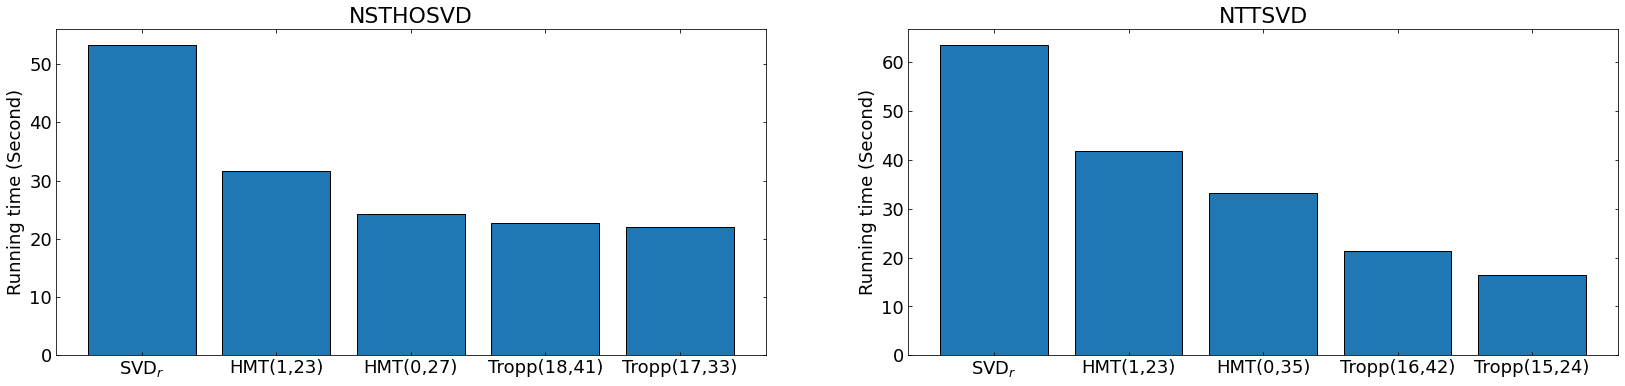

In [55]:
fig, ax = ex.plotRuntimes(figsize=(28, 6),
                          ylabelsize=18,
                          xticksize=18,
                          yticksize=18,
                          titlesize=22,
                          wspace=0.2)

# fig.savefig('figs/whu_runtimes.pdf', transparent=True, bbox_inches='tight')

In [59]:
ex.run(itersNum=itersNum)

NTTSVD
------------------------------------
SVD$_r$                  |  55.91 s.
HMT(1,23), Rad           |  56.95 s.
HMT(0,35), Rad           |  37.92 s.
Tropp(16,42), Rad        |  26.62 s.
Tropp(15,24), Rad        |  36.23 s.
------------------------------------
NSTHOSVD
------------------------------------
SVD$_r$                  |  65.98 s.
HMT(1,23), Rad           |  40.33 s.
HMT(0,27), Rad           |  27.04 s.
Tropp(18,41), Rad        |  38.99 s.
Tropp(17,33), Rad        |  28.38 s.
------------------------------------


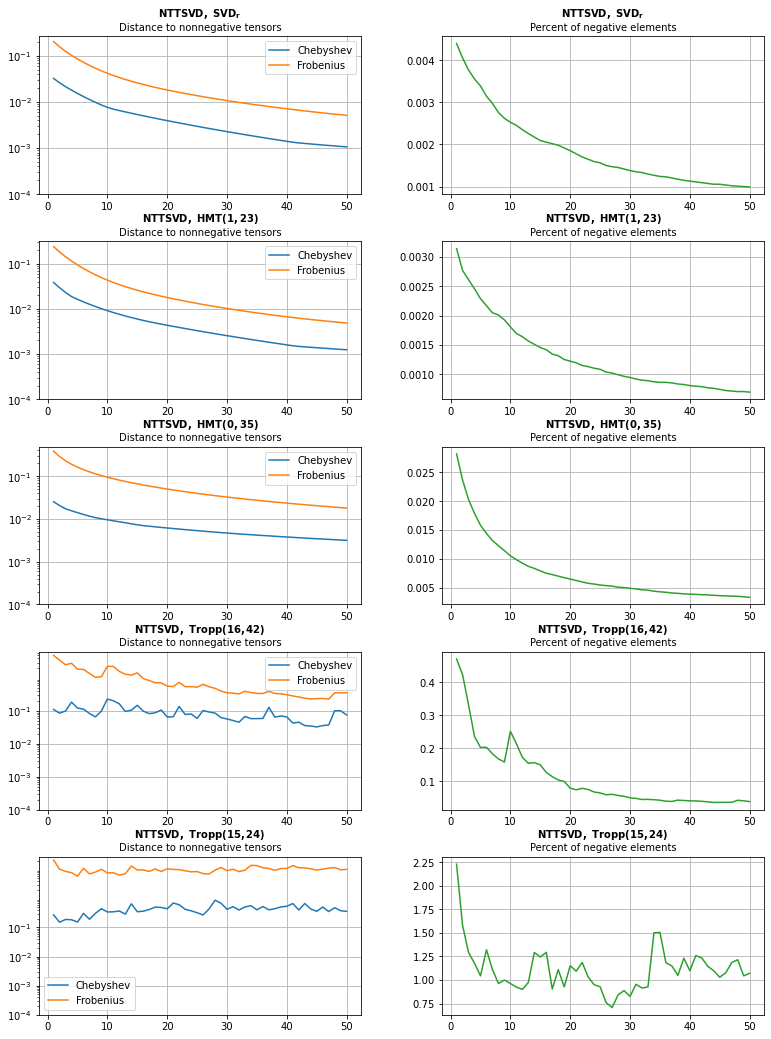

In [64]:
fig, ax = ex.plotConvergence2(hosvd=False,
                              figsize=(13, 18),
                              wspace=0.25,
                              hspace=0.3,
                              yticks=[10**(-x) for x in range(1, 5)])

# for i in range(ax.shape[0]):   
#     extent = ax[i,0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#     extent.x0 -= 0.5
#     extent.x1 += 5.7
#     extent.y1 += 0.5
#     extent.y0 -= 0.3
#     fname = 'figs/whu_conv_tt_%d.pdf' % i
#     fig.savefig(fname, transparent=True, bbox_inches=extent)

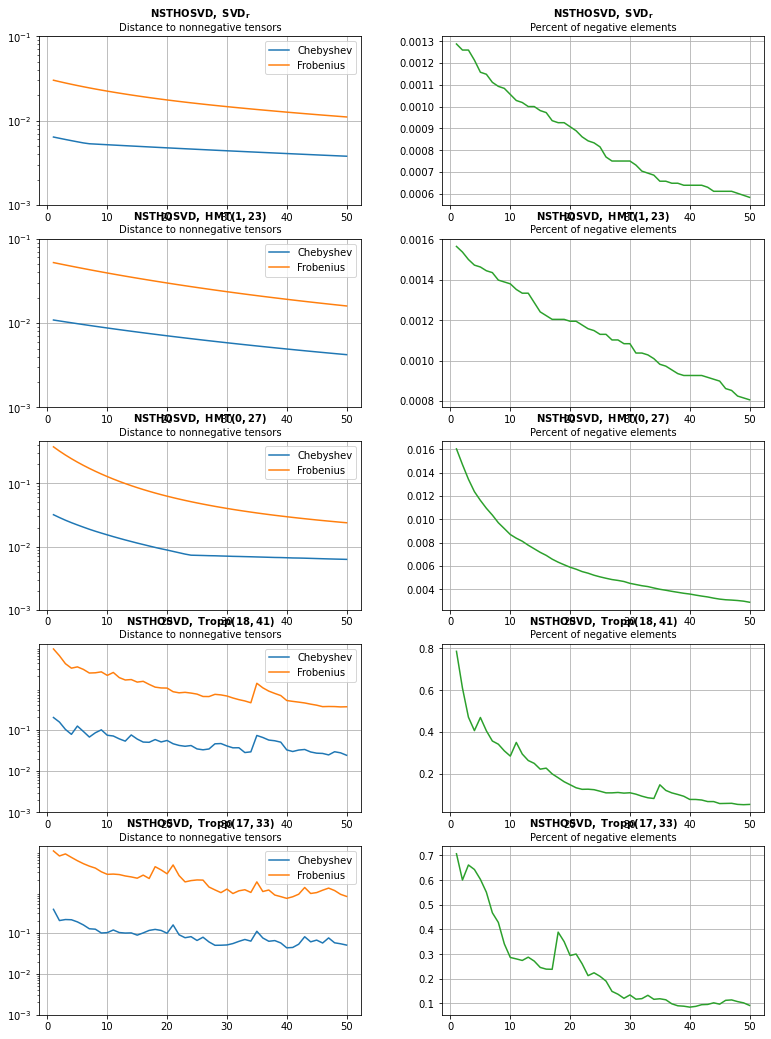

In [61]:
fig, ax = ex.plotConvergence2(ttsvd=False, figsize=(13, 18), wspace=0.25, yticks=[10**(-x) for x in range(1, 4)])

# for i in range(ax.shape[0]):   
#     extent = ax[i,0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#     extent.x0 -= 0.5
#     extent.x1 += 5.7
#     extent.y1 += 0.5
#     extent.y0 -= 0.3
#     fname = 'figs/whu_conv_ho_%d.pdf' % i
#     fig.savefig(fname, transparent=True, bbox_inches=extent)

In [62]:
ex.printErrors()

| NTTSVD                   | relative error (fro) | relative error (che) | r2_score |
------------------------------------------------------------------------------------
| SVD$_r$                  |              0.08249 |              0.28261 | 0.984317 |
| HMT(1,23), Rad           |              0.08325 |              0.27606 | 0.984031 |
| HMT(0,35), Rad           |              0.09742 |              0.33656 | 0.978133 |
| Tropp(16,42), Rad        |              0.16066 |              0.63288 | 0.940521 |
| Tropp(15,24), Rad        |              0.31500 |              1.33704 | 0.771362 |
------------------------------------------------------------------------------------
| NSTHOSVD                 | relative error (fro) | relative error (che) | r2_score |
------------------------------------------------------------------------------------
| SVD$_r$                  |              0.08296 |              0.26382 | 0.984138 |
| HMT(1,23), Rad           |              0.08366 |      

In [63]:
ex.printNegativeElements()

| NTTSVD                   | negative elements (%) |
----------------------------------------------------
| SVD$_r$                  |             0.0009907 |
| HMT(1,23), Rad           |             0.0006944 |
| HMT(0,35), Rad           |             0.0033333 |
| Tropp(16,42), Rad        |             0.0376389 |
| Tropp(15,24), Rad        |             1.0712500 |
----------------------------------------------------
| NSTHOSVD                 | negative elements (%) |
----------------------------------------------------
| SVD$_r$                  |             0.0005833 |
| HMT(1,23), Rad           |             0.0008056 |
| HMT(0,27), Rad           |             0.0028889 |
| Tropp(18,41), Rad        |             0.0533333 |
| Tropp(17,33), Rad        |             0.0915370 |
----------------------------------------------------


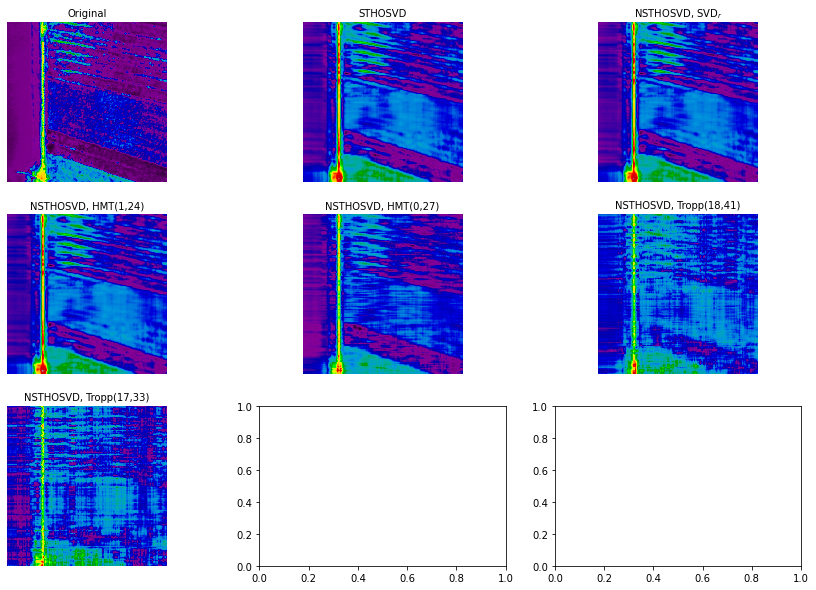

In [49]:
## HOSVD

fig, ax = ex.showApproximations(ttsvd=False, band=100, figsize=(15, 10), cmap='nipy_spectral')

# fig.savefig('figs/whu_approximations_ho.pdf', transparent=True, bbox_inches='tight')

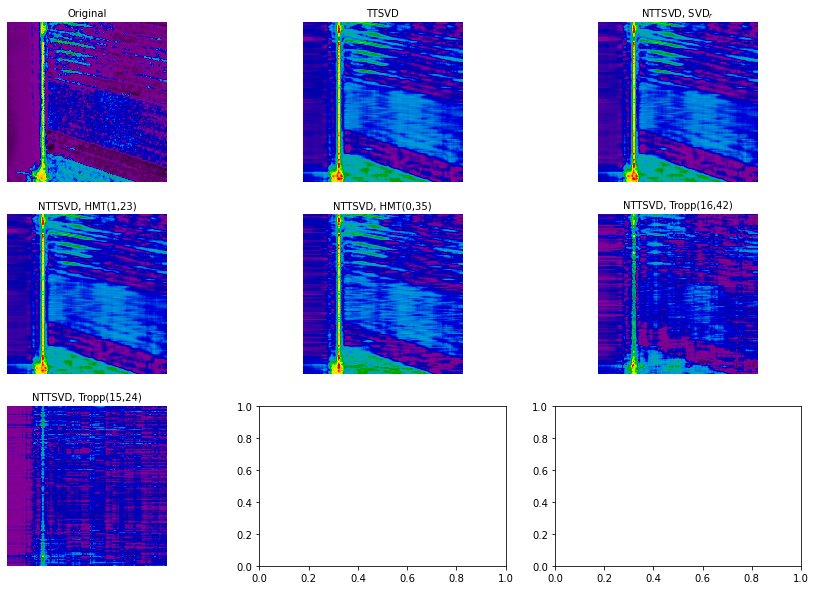

In [50]:
## TTSVD

fig, ax = ex.showApproximations(hosvd=False, band=100, figsize=(15, 10), cmap='nipy_spectral')

# fig.savefig('figs/whu_approximations_tt.pdf', transparent=True, bbox_inches='tight')

### 1.3. Pavia City Center
https://www.ehu.eus/ccwintco/index.php?title=Hyperspectral_Remote_Sensing_Scenes

shape: (103, 610, 340)
min_elem: 0.0
max_elem: 8000.0


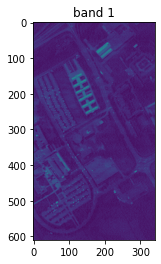

In [76]:
# original image

HSI_path = 'data/PaviaU.mat'
HSI_mat = spio.loadmat(HSI_path)
HSI_data = HSI_mat['paviaU']
HSI_data = np.moveaxis(HSI_data, -1, 0)

img = HSI_data

print('shape: %s\nmin_elem: %.1f\nmax_elem: %.1f' % (img.shape, img.min(), img.max()))
band = 1
plt.imshow(img[band])
plt.title(f'band {band}')
plt.show()

shape: (103, 310, 340)
min_elem: 0.0
max_elem: 1.0


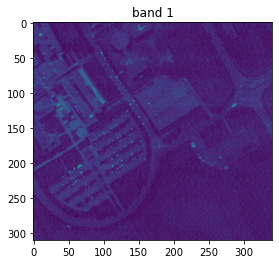

In [77]:
# subimage

HSI_path = 'data/PaviaU.mat'
HSI_mat = spio.loadmat(HSI_path)
HSI_data = HSI_mat['paviaU']
HSI_data = np.moveaxis(HSI_data, -1, 0) / HSI_data.max()

img = HSI_data[:, 300:, :]

print('shape: %s\nmin_elem: %.1f\nmax_elem: %.1f' % (img.shape, img.min(), img.max()))
band = 1
plt.imshow(img[band])
plt.title(f'band {band}')
plt.show()

# 3. Function Based Tensors

## 3.1 Hilbert Tensor

An Nth order Hilbert tensor is defined as follows
$$A(i_1, \dots, i_N) = \frac{1}{i_1 + \dots + i_N - N + 1}$$

In [28]:
shape = [128, 128, 128]

a = np.empty(shape=shape)

m, n, l = a.shape
for i in range(m):
    for j in range(n):
        for k in range(l):
            a[i, j, k] = 1 / ((i+1) + (j+1) + (k+1) - 3 + 1)

In [29]:
svdrList = []
svdrList.append(Svdr('SVD'))
svdrList.append(Svdr('HMT',   p=0,  k=7, distr='rademacher'))
svdrList.append(Svdr('Tropp', k=7, l=9, distr='rademacher'))

hoRanks = (3, 2, 4)
ttRanks = (3, 2)
itersNum = 250

ex = Experiment(tensor=a)
ex.setRanks(hoRanks=hoRanks, ttRanks=ttRanks)
ex.setSvdrList(svdrList)

In [30]:
ex.runInitialSvd()

TTSVD
----------------------------------------
time (s.)                    |   0.40592
negative elements (fro)      |   0.09768
negative elements (che)      |   0.01631
negative elements (%)        |   0.00634
relative error (fro)         |   0.07719
relative error (che)         |   0.36718
r2_score                     |   0.97986
compression                  |   1489.45
----------------------------------------
STHOSVD
----------------------------------------
time (s.)                    |   0.45241
negative elements (fro)      |   0.09754
negative elements (che)      |   0.01629
negative elements (%)        |   0.00634
relative error (fro)         |   0.07719
relative error (che)         |   0.36718
r2_score                     |   0.97986
compression                  |   1783.29
----------------------------------------


In [31]:
ex.timeit(itersNum=itersNum)

NTTSVD
------------------------------------
SVD$_r$                 | 115.83 s.
HMT(0,7), Rad           |   9.11 s.
Tropp(7,9), Rad         |   9.61 s.
------------------------------------
NSTHOSVD
------------------------------------
SVD$_r$                 | 115.28 s.
HMT(0,7), Rad           |   9.82 s.
Tropp(7,9), Rad         |  11.71 s.
------------------------------------


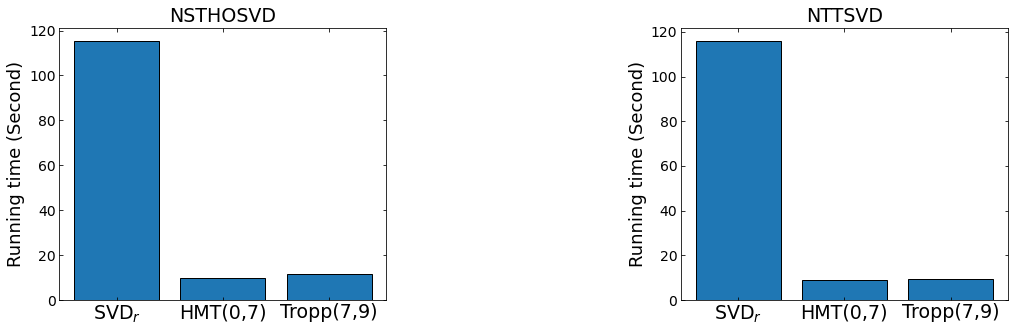

In [32]:
fig, ax = ex.plotRuntimes(figsize=(17, 5),
                          titlesize=19,
                          ylabelsize=18,
                          xticksize=19,
                          yticksize=14,
                          wspace=0.9)

# fig.savefig('figs/hilbert_runtimes.pdf', transparent=True, bbox_inches='tight')

In [33]:
ex.run(itersNum=itersNum)

NTTSVD
------------------------------------
SVD$_r$                  | 105.17 s.
HMT(0,7), Rad            |  14.71 s.
Tropp(7,9), Rad          |  12.42 s.
------------------------------------
NSTHOSVD
------------------------------------
SVD$_r$                  | 101.15 s.
HMT(0,7), Rad            |  15.39 s.
Tropp(7,9), Rad          |  13.91 s.
------------------------------------


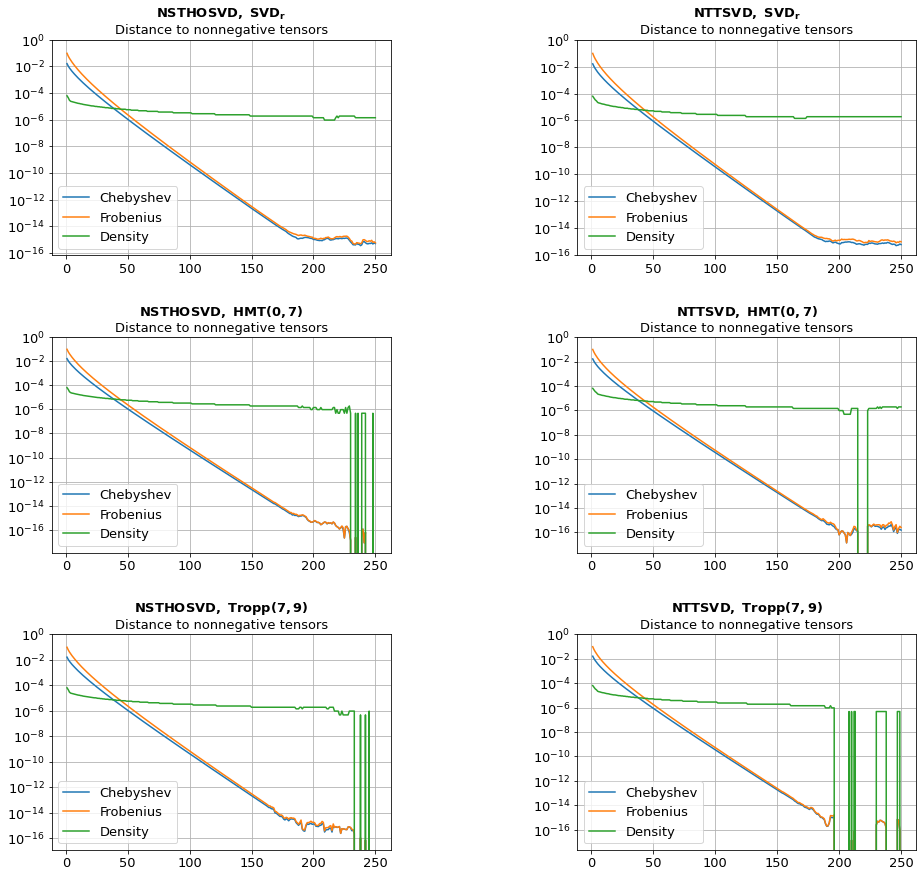

In [34]:
fig, ax = ex.plotConvergence(figsize=(15.5, 14.9),
                             yticks=[10**(-x) for x in range(0, 17, 2)],
                             hspace=0.38, wspace=0.55,
                             titlesize=13,
                             ticksize=13,
                             legendsize=13,
                             legendloc='lower left')

# for i in range(ax.shape[0]):   
#     extent = ax[i,0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#     extent.x0 -= 0.8
#     extent.x1 += 7.5
#     extent.y1 += 0.5
#     extent.y0 -= 0.3
#     fname = 'figs/hilbert_conv_%d.pdf' % i
#     fig.savefig(fname, transparent=True, bbox_inches=extent)

In [35]:
ex.printErrors()

| NTTSVD                   | relative error (fro) | relative error (che) | r2_score |
------------------------------------------------------------------------------------
| SVD$_r$                  |              0.07882 |              0.39445 | 0.979003 |
| HMT(0,7), Rad            |              0.07882 |              0.39444 | 0.979002 |
| Tropp(7,9), Rad          |              0.07882 |              0.39477 | 0.979004 |
------------------------------------------------------------------------------------
| NSTHOSVD                 | relative error (fro) | relative error (che) | r2_score |
------------------------------------------------------------------------------------
| SVD$_r$                  |              0.07895 |              0.39500 | 0.978935 |
| HMT(0,7), Rad            |              0.07895 |              0.39492 | 0.978935 |
| Tropp(7,9), Rad          |              0.07895 |              0.39481 | 0.978936 |
---------------------------------------------------------

# 4. Stochastic cubical tensors

In [257]:
# graph generators

import networkx as nx
import algorithms

gilbert    = lambda n: nx.to_numpy_array(nx.binomial_graph(n, p=0.5, directed=False))
smallw     = lambda n: nx.to_numpy_array(nx.navigable_small_world_graph(int(n ** 0.5)))
geo        = lambda n: nx.to_numpy_array(nx.random_geometric_graph(n, radius=(1.44/n)**0.5, dim=2, p=2))
pref       = lambda n: nx.to_numpy_array(nx.barabasi_albert_graph(n, m=2))
rank1      = lambda n: np.ones((n, n))

# erdrey     = lambda n: nx.to_numpy_array(nx.erdos_renyi_graph(n, p=0.5, directed=True))
# lockandkey = lambda n:

g = [gilbert, smallw, geo, pref, rank1]

def get_stochatic_tensor(n, m): ## PageRank, Alg. 2
    P = np.zeros((n, n**(m-1)))
    for i in range(1, n**(m-2) + 1):
        gr = g[np.random.choice(range(len(g)))]
        P[:, (i-1)*n:i*n] = gr(n)
    col_sums = P.sum(axis=0)
    zero_cols = np.where(col_sums == 0)
    for col in zero_cols:
        row = np.random.choice(range(n))
        P[row, col] = 1
    col_sums[col_sums == 0] = 1
    P /= col_sums
    return algorithms.fold(P, mode=0, shape=(n,)*m)

In [263]:
a = get_stochatic_tensor(81, 3)
print(a.shape, a.min(), a.max())

hoRanks = (30, 30, 40)
ttRanks = (30, 30)

ex = Experiment(tensor=a)
ex.setRanks(hoRanks=hoRanks, ttRanks=ttRanks)

ex.runInitialSvd()

(81, 81, 81) 0.0 1.0
TTSVD
----------------------------------------
time (s.)                    |   0.04592
negative elements (fro)      |   6.21689
negative elements (che)      |   0.22090
negative elements (%)        |  18.46884
relative error (fro)         |   0.82160
relative error (che)         |   0.97941
r2_score                     |   0.28118
compression                  |      6.83
----------------------------------------
STHOSVD
----------------------------------------
time (s.)                    |   0.05006
negative elements (fro)      |   5.83725
negative elements (che)      |   0.21723
negative elements (%)        |  17.37070
relative error (fro)         |   0.81465
relative error (che)         |   0.97791
r2_score                     |   0.29330
compression                  |     12.05
----------------------------------------


### 4.1

In [227]:
def get_stochatic_tensor(shape):
    tensor = np.random.uniform(low=0.0, high=1.0, size=shape)
    mode_1 = algorithms.unfold(tensor, mode=1)
    mode_1 = mode_1 / mode_1.sum(axis=0)
    return algorithms.fold(mode_1, mode=1, shape=shape)

In [231]:
n = 128
shape = (n, n, n)
a = get_stochatic_tensor(shape)

hoRanks = (10, 10, 10)
ttRanks = (10, 10)

ex = Experiment(tensor=a)
ex.setRanks(hoRanks=hoRanks, ttRanks=ttRanks)

ex.runInitialSvd()

TTSVD
----------------------------------------
time (s.)                    |   0.43172
negative elements (fro)      |   0.00000
negative elements (che)      |   0.00000
negative elements (%)        |   0.00000
relative error (fro)         |   0.49761
relative error (che)         |   0.59295
r2_score                     |   0.01086
compression                  |    136.53
----------------------------------------
STHOSVD
----------------------------------------
time (s.)                    |   0.42174
negative elements (fro)      |   0.00000
negative elements (che)      |   0.00000
negative elements (%)        |   0.00000
relative error (fro)         |   0.49959
relative error (che)         |   0.60253
r2_score                     |   0.00297
compression                  |    433.30
----------------------------------------
